# Import libraries

In [22]:
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
pd.set_option('display.max_colwidth', None)

# Create corpus and Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [23]:
# Define the remove_non_english function
def remove_non_english(text):
    # Regular expression to remove non-English alphabet characters
    english_only = re.sub(r'[^a-zA-Z\s.,;?!\'-]', '', text)
    return english_only

# Define the create_corpus function
def create_corpus(text):
    # Tokenize text into sentences
    sentences = text.split('\n')
    # Remove empty strings
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Join sentences into a corpus
    corpus = '\n'.join(sentences)  # Keep newline characters
    return corpus

# Read the CSV file
csv_path = "../../../data_raw/our_dataset.csv"
df = pd.read_csv(csv_path)

# Apply remove_non_english function to poem column
df['poem'] = df['poem'].apply(remove_non_english)

# Apply create_corpus function to poem column
df['poem'] = df['poem'].apply(create_corpus)

# Remove \xa0
df['poem'] = df['poem'].str.replace('\xa0', '')

# Apply lowercase to the poem column
df['poem'] = df['poem'].str.lower()

# Print the DataFrame
df


,Unnamed: 0,poem,topic
0,0,"sunday we lay hands\non a girl of ten hand on hand on\ncornsilk hair. we sing\nthe secret language sung\nthe day the tin roof of the tower beat\non gods floorboard\nhe got cramp in heaven.\nlike our crying and our\nfornicating so close to his bed\nwas so many shrill mice in a pretty\npine floor. to heal\nthe girl with the crippled up leg\ngod sends back the song\nhe took and down it comes\ncontrary in one mouth as fire\ngentle on our bodies as rain.\nsoft rain swells the cumberland\nand all her fields in april nuzzles\nbuttercups the mules wont touch\nthe crowpoison the wake-robin\nthe bluets of the field.\nevery song got a beat beneath.\nstart with the whippoorwill\nearly meadow colors creep\ninto the sky. my sons made this\ntobacco sled i prime with the jenny\ntoss the last of the sandlugs for the rest\nto thrive. so hot the wasps hang on the honeysuckle\ntoo spent to buzz a sermon.\ni know my song remembers\nwhat my fathers told their strings.\ndriskill, kentuckydriskill, kentucky",religion
1,1,"o transientvoyager of heaven!\no silent sign of winter skies!\nwhat adverse wind thy sail has driven\nto dungeons where a prisoner lies?\nmethinks the hands that shut the sun\nso sternly from this morning's brow\nmight still their rebel task have done\nand checked a thing so frail as thou.\nthey would have done it had they known\nthe talisman that dwelt in thee,\nfor all the suns that ever shone\nhave never been so kind to me!\nfor many a week, and many a day\nmy heart was weighed with sinking gloom\nwhen morning rose in mourning grey\nand faintly lit my prison room\nbut angel like, when i awoke,\nthy silvery form, so soft and fair\nshining through darkness, sweetly spoke\nof cloudy skies and mountains bare;\nthe dearest to a mountaineer\nwho, all life long has loved the snow\nthat crowned his native summits drear,\nbetter, than greenest plains below.\nand voiceless, soulless, messenger\nthy presence waked a thrilling tone\nthat comforts me while thou art here\nand will sustain when thou art gone",religion
2,2,"a cento for sarah hegazy\na cento for sarah hegazy\na cento for sarah hegazyin the hiding\nhour of autophagy\nghosts hang out all day and talk to us.\nan archival haunting demanding tribute\nhalf a lime for breakfast every day.\nhuman voices keening in pain\ntheir bodies, consumed by fire\nlight up the dark\n.\nthey will blame the early morning hours\nunder the seal of secrecy\nwhere there was no sunrise\nthough\nmoon tells me god is love unconditional. i\nten thousand years old and no wind\nmilk souring on my tongue\nwhisper until we sleep\ndo you see the map home?\nthis world will have you running to stone for embrace\ngravestone gentler than human.\nthe wretched left a monument of comments that day\nin the place of thunder,\ni have faith in a world of signs and wonder.\nthis time it will be different\narab spring forcing its way\nold life re-members\nlightening would manifest from the stale air.\nyou are prepared for all of it\nparaded processions wedding ecstatic\nwhen the fists rush towards your gut\nthey will find instead smoke.\nour desire up to our throats,\nincreased blood flow ripping heart open from within\ndead now after decimating perfectly healthy skin\nwe will become history contested.\na light in the earth of her chest.\ngrief is a country without borders\neulogy to be read from right to left\nbabas tongue buried in sand\ni dream in arabic of salt drink gallons\nbut the ocean stays the ocean and once again i wake\nam a wake in english.\nim thirsty is whats killing me most.\ndont die this way.\nwake up drink water one foot and then the next walk meet the sun\na face that is so itself\nto look upon it on that summer day was like drinking\nprism refracting rainbow\nrupture rapture\nwho washed her, who folded her into eternity, who\nthis is the only river i want to write about.\ni am the entire galaxy in a drop.\ndont you know i am everything?\nan absconded city of bees.\na novel adject

In [24]:
# Create an empty list to store lines of text
corpus = []

# Initialize a counter for the number of lines added to the corpus
line_count = 0

# Iterate over each poem in the DataFrame
for poem in df['poem']:
    # Split the poem into lines
    lines = poem.split('\n')
    # Iterate over each line in the poem
    for line in lines:
        # Append the line to the corpus
        corpus.append(line)
        # Increment the line count
        line_count += 1
        # Check if the corpus has reached the maximum size of 10,000 lines
        if line_count >= 10000:
            break
    # Check if the corpus has reached the maximum size of 10,000 lines
    if line_count >= 10000:
        break
    
corpus[:10]


['sunday we lay hands',
 'on a girl of ten hand on hand on',
 'cornsilk hair. we sing',
 'the secret language sung',
 'the day the tin roof of the tower beat',
 'on gods floorboard',
 'he got cramp in heaven.',
 'like our crying and our',
 'fornicating so close to his bed',
 'was so many shrill mice in a pretty']

In [25]:
len(corpus)

10000

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [27]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 13448


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [28]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 67317
Maximum n-gram length: 1646


In [29]:
for n_gram in n_grams[:10]:
    print(n_gram)

[541, 27]
[541, 27, 576]
[541, 27, 576, 207]
[16, 4]
[16, 4, 315]
[16, 4, 315, 3]
[16, 4, 315, 3, 818]
[16, 4, 315, 3, 818, 132]
[16, 4, 315, 3, 818, 132, 16]
[16, 4, 315, 3, 818, 132, 16, 132]


## Pad n-grams

In [30]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(67317, 100)

In [31]:
for seq in padded_n_grams[:3]:
    print(seq)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 541  27]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 541  27 576]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

## Split n-grams into X and y

In [32]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (67317, 99)
y: (67317,)


In [33]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (67317, 13448)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [34]:
import tensorflow.keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def perplexity_m(y_true, y_pred):
    # Clip predictions to prevent log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    # Calculate the cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    # Calculate the perplexity
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity

In [35]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", f1_m, precision_m, recall_m, perplexity_m]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(
    X, 
    y, 
    epochs=125,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/125
526/526 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.0547 - f1_m: 0.0000e+00 - loss: 7.8745 - perplexity_m: 3428.3618 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/125
526/526 ━━━━━━━━━━━━━━━━━━━━ 96s 183ms/step - accuracy: 0.0704 - f1_m: 9.1060e-06 - loss: 7.0694 - perplexity_m: 1211.1666 - precision_m: 5.8733e-04 - recall_m: 4.5886e-06
Epoch 3/125
526/526 ━━━━━━━━━━━━━━━━━━━━ 107s 204ms/step - accuracy: 0.0800 - f1_m: 9.6304e-04 - loss: 6.8139 - perplexity_m: 931.0045 - precision_m: 0.0542 - recall_m: 4.8624e-04
Epoch 4/125
526/526 ━━━━━━━━━━━━━━━━━━━━ 108s 205ms/step - accuracy: 0.0905 - f1_m: 0.0070 - loss: 6.5929 - perplexity_m: 749.0889 - precision_m: 0.3355 - recall_m: 0.0035
Epoch 5/125
526/526 ━━━━━━━━━━━━━━━━━━━━ 108s 206ms/step - accuracy: 0.0986 - f1_m: 0.0158 - loss: 6.3574 - perplexity_m: 592.2366 - precision_m: 0.5681 - recall_m: 0.0081
Epoch 6/125
526/526 ━━━━━━━━━━━━━━━━━━━━ 105s 200ms/step - accuracy: 0.1095 - f1_m: 0.0283 - loss: 6.1323 - p

# Plot learning curves

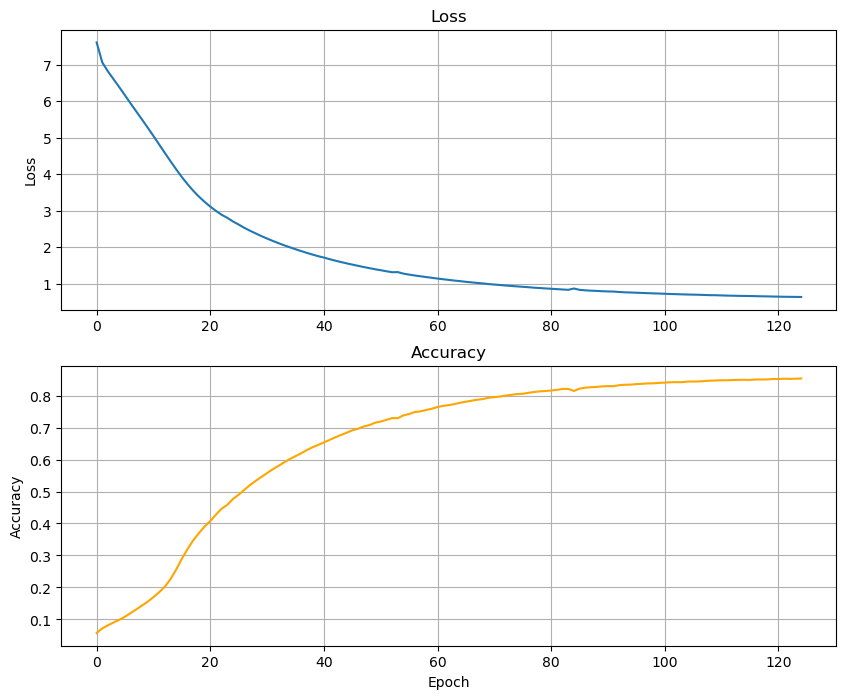

In [37]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

In [38]:
# Evaluate the model
results = model.evaluate(X, y, verbose=0)
loss, accuracy, f1_score, precision, recall, perplexity_value = results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test F1 Score: {f1_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test Perplexity: {perplexity_value}")

Test Loss: 0.5757072567939758
Test Accuracy: 0.8663487434387207
Test F1 Score: 0.8976229429244995
Test Precision: 1.8799673318862915
Test Recall: 0.9831269383430481
Test Perplexity: 0.8304851651191711


# Poetry generation

In [39]:
def generate(seed_text, next_words):
    generated_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        else:
            generated_text += output_word + " "
        seed_text += " " + output_word
    print(seed_text)

In [40]:
generate("Long live the king", 200)

Long live the king of men in which has become bed through the truth for guidance there is a prayer for rain there is no answer since i am touching everything you cannot see here the so kind of us who has they ask the new people look at my sisters who is as here does not ask to be part of your america though are we not america her joints brittle dragging a ripped gown through oakland i cant stand your ground im sick of calling your recklessness the law each night i count my brothers in the morning when some do not survive to be counted i count the holes they leave i reach for black folks touch only air your master magic trick america now hes breathing now he dont abra cadaver white bread voodoo sorcery you claim not to practice hand my cousin a pistol to do your work i tried white people i tried to love you but you spent my brothers funeral making plans for brunch talking too loud next to his bones you took one look at the river plump with the body of boy after girl after sweet boi ask 